## Based on https://github.com/lerocha/chinook-database

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
conn = sql.connect('chinook.db')

In [10]:
conn.execute('select * from sqlite_master').fetchall()

[('table',
  'album',
  'album',
  2,
  'CREATE TABLE [album]\n(\n    [album_id] INTEGER PRIMARY KEY NOT NULL,\n    [title] NVARCHAR(160)  NOT NULL,\n    [artist_id] INTEGER  NOT NULL,\n    FOREIGN KEY ([artist_id]) REFERENCES [artist] ([artist_id]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)'),
 ('table',
  'artist',
  'artist',
  3,
  'CREATE TABLE [artist]\n(\n    [artist_id] INTEGER PRIMARY KEY NOT NULL,\n    [name] NVARCHAR(120)\n)'),
 ('table',
  'customer',
  'customer',
  4,
  'CREATE TABLE [customer]\n(\n    [customer_id] INTEGER PRIMARY KEY NOT NULL,\n    [first_name] NVARCHAR(40)  NOT NULL,\n    [last_name] NVARCHAR(20)  NOT NULL,\n    [company] NVARCHAR(80),\n    [address] NVARCHAR(70),\n    [city] NVARCHAR(40),\n    [state] NVARCHAR(40),\n    [country] NVARCHAR(40),\n    [postal_code] NVARCHAR(10),\n    [phone] NVARCHAR(24),\n    [fax] NVARCHAR(24),\n    [email] NVARCHAR(60)  NOT NULL,\n    [support_rep_id] INTEGER,\n    FOREIGN KEY ([support_rep_id]) REFERENCES [empl

In [22]:
#individual sale analysis
q1 = 'select tr.track_id, tr.name as track_name, ar.name AS artist_name, mt.name AS track_type, tr.unit_price, il.quantity  from track AS tr inner join (select * from invoice_line where invoice_id = 4) as il on tr.track_id=il.track_id inner join media_type AS mt on tr.media_type_id=mt.media_type_id INNER JOIN album AS al ON tr.album_id = al.album_id INNER JOIN artist AS ar ON al.artist_id = ar.artist_id'
q1r = pd.read_sql_query(q1, conn)
q1r

,track_id,track_name,artist_name,track_type,unit_price,quantity
0,3448,"Lamentations of Jeremiah, First Set \ Incipit ...",The King's Singers,Protected AAC audio file,0.99,1
1,2560,Violent Pornography,System Of A Down,MPEG audio file,0.99,1
2,3336,War Pigs,Cake,Purchased AAC audio file,0.99,1
3,829,Let's Get Rocked,Def Leppard,MPEG audio file,0.99,1
4,1872,Attitude,Metallica,MPEG audio file,0.99,1
5,748,Dealer,Deep Purple,MPEG audio file,0.99,1
6,1778,You're What's Happening (In The World Today),Marvin Gaye,MPEG audio file,0.99,1
7,2514,Spoonman,Soundgarden,MPEG audio file,0.99,1


In [30]:
#the best selling authors
q2 = "select al.title AS album, ar.name AS artist, SUM(il.quantity) AS tracks_purchased from invoice_line AS il INNER JOIN track AS tr ON il.track_id = tr.track_id INNER JOIN album AS al ON tr.album_id = al.album_id INNER JOIN artist AS ar ON al.artist_id = ar.artist_id GROUP BY album ORDER BY 3 desc LIMIT 5"
q2r= pd.read_sql_query(q2,conn)
q2r

,album,artist,tracks_purchased
0,Are You Experienced?,Jimi Hendrix,187
1,Faceless,Godsmack,96
2,Mezmerize,System Of A Down,93
3,Get Born,JET,90
4,The Doors,The Doors,83


In [42]:
#employee hierarhy structure
q3="SELECT e1.first_name || ' '|| e1.last_name AS employee_name, e1.title AS employee_title, e2.first_name || ' ' || e2.last_name AS supervisor_name, e2.title AS supervisor_title  FROM employee AS e1 LEFT JOIN employee AS e2 ON e1.reports_to = e2.employee_id ORDER BY 1 asc"

q3r=pd.read_sql_query(q3,conn)
q3r

,employee_name,employee_title,supervisor_name,supervisor_title
0,Andrew Adams,General Manager,None,None
1,Jane Peacock,Sales Support Agent,Nancy Edwards,Sales Manager
2,Laura Callahan,IT Staff,Michael Mitchell,IT Manager
3,Margaret Park,Sales Support Agent,Nancy Edwards,Sales Manager
4,Michael Mitchell,IT Manager,Andrew Adams,General Manager
5,Nancy Edwards,Sales Manager,Andrew Adams,General Manager
6,Robert King,IT Staff,Michael Mitchell,IT Manager
7,Steve Johnson,Sales Support Agent,Nancy Edwards,Sales Manager


In [5]:
#pattern search
q4 = 'SELECT first_name, last_name, phone FROM customer WHERE first_name LIKE "%belle%"'
q4r = pd.read_sql_query(q4,conn)
q4r

,first_name,last_name,phone
0,Isabelle,Mercier,+33 03 80 73 66 99


In [9]:
#Portfolio summary 
q5 = "select pl.playlist_id, pl.name as Genre, count(tr.track_id) as No_tracks from playlist AS pl left join playlist_track AS pt on pl.playlist_id = pt.playlist_id left join track AS tr ON pt.track_id = tr.track_id group by 1"
q5r = pd.read_sql_query(q5,conn)
q5r

,playlist_id,Genre,No_tracks
0,1,Music,3290
1,2,Movies,0
2,3,TV Shows,213
3,4,Audiobooks,0
4,5,90’s Music,1477
5,6,Audiobooks,0
6,7,Movies,0
7,8,Music,3290
8,9,Music Videos,1
9,10,TV Shows,213


### the best customers in every country

In [41]:
q6 = 'select *, sum(total) from invoice group by customer_id'
q6r = pd.read_sql_query(q6, conn)

In [44]:
##1.step best customers id in each country
country = q6r['billing_country'].unique()
bests = pd.DataFrame()
for i in country:
    q = q6r.loc[q6r['billing_country'] == i].sort_values('sum(total)', ascending=False)
    bests = bests.append(q[:1])
bests[['customer_id', 'billing_country','sum(total)']]

,customer_id,billing_country,sum(total)
0,1,Brazil,108.90
36,37,Germany,94.05
2,3,Canada,99.99
3,4,Norway,72.27
4,5,Czech Republic,144.54
6,7,Austria,69.30
7,8,Belgium,60.39
8,9,Denmark,37.62
16,17,USA,98.01
33,34,Portugal,102.96


In [55]:
##2.step best customers name
q7 = 'select customer_id, first_name || \' \'||last_name AS Customer_name, city, country from customer'
q7r = pd.read_sql_query(q7, conn)
q7r.iloc[bests.index]

,customer_id,Customer_name,city,country
0,1,Luís Gonçalves,São José dos Campos,Brazil
36,37,Fynn Zimmermann,Frankfurt,Germany
2,3,François Tremblay,Montréal,Canada
3,4,Bjørn Hansen,Oslo,Norway
4,5,František Wichterlová,Prague,Czech Republic
6,7,Astrid Gruber,Vienne,Austria
7,8,Daan Peeters,Brussels,Belgium
8,9,Kara Nielsen,Copenhagen,Denmark
16,17,Jack Smith,Redmond,USA
33,34,João Fernandes,Lisbon,Portugal


In [71]:
##3. step merge of tables
bestslist=pd.merge(bests[['billing_country','sum(total)']],q7r, left_index=True, right_index=True, how='left')
bestlist= bestslist[['customer_id','Customer_name','city', 'country', 'sum(total)']].sort_values('country').reset_index(drop=True)
bestlist

,customer_id,Customer_name,city,country,sum(total)
0,56,Diego Gutiérrez,Buenos Aires,Argentina,39.60
1,55,Mark Taylor,Sidney,Australia,81.18
2,7,Astrid Gruber,Vienne,Austria,69.30
3,8,Daan Peeters,Brussels,Belgium,60.39
4,1,Luís Gonçalves,São José dos Campos,Brazil,108.90
5,3,François Tremblay,Montréal,Canada,99.99
6,57,Luis Rojas,Santiago,Chile,97.02
7,5,František Wichterlová,Prague,Czech Republic,144.54
8,9,Kara Nielsen,Copenhagen,Denmark,37.62
9,44,Terhi Hämäläinen,Helsinki,Finland,79.20


In [170]:
conn.close()

In [2]:
#defining functions to common tasks
def query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql_query(q,conn)
        conn.close()

### Who is the best seller?

In [208]:
q = '''
with sales AS (
SELECT 
    COUNT(i.invoice_id) AS sales,
    c.customer_id AS customer,
    support_rep_id AS agent,
    SUM(i.total) AS total
FROM invoice AS i
INNER JOIN customer AS c
ON i.customer_id = c.customer_id
GROUP BY c.customer_id )

SELECT 
    COUNT(customer) AS customer_no,
    COUNT(sales) AS sales_no,
    SUM(s.total) AS value,
    e.first_name||' '||e.last_name AS sales_person,
    e.title,
    (DATETIME('now') - e.birthdate) AS Age
FROM sales AS s
INNER JOIN employee as e
ON s.agent = e.employee_id
GROUP BY 4
    
'''

seller =query(q)
seller

,customer_no,sales_no,value,sales_person,title,Age
0,21,21,1731.51,Jane Peacock,Sales Support Agent,45
1,20,20,1584.00,Margaret Park,Sales Support Agent,71
2,18,18,1393.92,Steve Johnson,Sales Support Agent,53


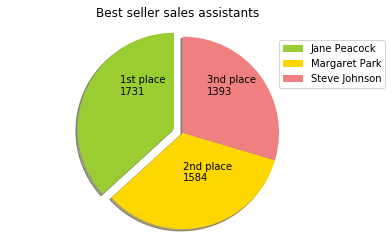

In [287]:
#plt.pie(seller['value'].astype('int'), seller['sales_person']);

labels = seller['sales_person'].tolist()
sizes = seller['value'].tolist()
colors = ['yellowgreen', 'gold', 'lightcoral']
explode = (0.1, 0.0,0.0)
plt.pie(sizes, colors=colors, explode=explode, shadow=True, startangle=90)
plt.legend(labels, loc=(0.8,0.7))

plt.annotate(('1st place \n' +str(int(seller.loc[0,'value']))), (-0.65, 0.4))
plt.annotate('2nd place \n' +(str(int(seller.loc[1,'value']))), (0, -0.5))
plt.annotate('3nd place \n' +str(int(seller.loc[2,'value'])), (0.25,0.4))
plt.axis('equal')
plt.title('Best seller sales assistants')
plt.show()